# Bayesian Approach to Problem

## Observed Stars

To try to get an idea of what's going wrong, I am going to approach the problem from a Bayesian perspective in an effort to understand what the probability is of a certain observed star actually being a true star and vice-reversa. Using Baye's law, we can arrive at:

$$P\left( T_S|O_S\right) = \frac{P\left( O_S|T_S\right) P\left( O_S|T_G\right) - P\left( O_S\right) P\left( O_S|T_S\right)}{P\left( O_S\right) \left( P\left( O_S|T_G\right) - P\left( O_S|T_S\right)\right)}$$

The term $P\left( O_S|T_G\right)$ is never explicitly calculated in my pipeline, so it will be substituted for $1 - P\left( O_G|T_G\right)$. This gives an equation of:

$$P\left( T_S|O_S\right) = \frac{P\left( O_S|T_S\right) \left( P\left( O_G|T_G\right) + P\left( O_S\right) - 1  \right)}{P\left( O_S\right) \left( P\left( O_G|T_G\right) + P\left( O_S|T_S\right) - 1\right)}$$

These conditional probabilities are all things that are calculated using Balrog. The actual $P\left( O_S\right)$ term can be calculated live as the probability of a detected object being a star. Since $P\left( O_S\right)$ is always be positive, as is (at least in theory) $P\left( O_S|T_S\right)$ I will instead look at the term:

$$\frac{P\left( O_G|T_G\right) + P\left( O_S\right) - 1}{P\left( O_G|T_G\right) + P\left( O_S|T_S\right) - 1}$$

This term will have the same sign as $P\left( T_S|O_S\right)$. In the magnitudes I'm looking at, the denominator will always or almost always be positive, so for sign only I can look at the term:

$$P\left( O_G|T_G\right) + P\left( O_S\right) - 1$$

## Observed Galaxies

$$P\left( T_S|O_G\right) = \frac{P\left( O_G|T_S\right) P\left( O_G|T_G\right) - P\left( O_G\right) P\left( O_G|T_S\right)}{P\left( O_G\right) \left( P\left( O_G|T_G\right) - P\left( O_G|T_S\right)\right)}$$

We know that $P\left( O_G|T_S\right) = 1 - P\left( O_S|T_S\right)$, so we get:

$$P\left( T_S|O_G\right) = \frac{\left( 1 - P\left( O_S|T_S\right)\right) \left( P\left( O_G|T_G\right) + P\left( O_S\right) -1\right)}{P\left( O_G\right) \left( P\left( O_G|T_G\right) + P\left( O_S|T_S\right) - 1\right)}$$

Like before, we know that $P\left( O_G\right)$ will be positive and $\left( 1 - P\left( O_S|T_S\right)\right)$ should be positive, so the sign will be the same as:

$$\frac{P\left( O_G|T_G\right) + P\left( O_S\right) - 1}{P\left( O_G|T_G\right) + P\left( O_S|T_S\right) - 1}$$

The denominator of this should be positive for all of the magnitudes I'm currently focusing on, so the sign we will be looking for is from:

$$P\left( O_G|T_G\right) + P\left( O_S\right) - 1$$

This is the same sign as before. So lets hope it's positive.

## Analysis

We have seen that with a few assumptions, the biggest of which is that $P\left( O_G|T_G\right) + P\left( O_S|T_S\right) > 1$, the sign of the probabilities we're after correspond to $P\left( O_G|T_G\right) + P\left( O_S\right) - 1$. This intuitively makes sense, as our assumption is really that $P\left( O_G|T_G\right)$ and $P\left( O_S|T_S\right)$ are both close to one. In this case, $P\left( O_G|T_G\right) + P\left( O_S\right) - 1$ will be positive since we will have $P\left( O_S\right) = P\left( O_S|T_S\right) P\left( T_S\right) + P\left( O_S|T_G\right) P\left( T_G\right) > P\left( O_S|T_G\right)$ which is true since by assumption $P\left( O_S|T_S\right) > P\left( O_S|T_G\right)$. The question is now where this assumption actually winds up breaking down, since clearly it isn't working on large scales.

The first test will be whether or not the assumption that $P\left( O_G|T_G\right) + P\left( O_S|T_S\right) > 1$ is actually holding across the sky at the magnitudes I've been looking at. The magnitudes I will be looking at are primarily $g<24$, but this may be extended to $g<25$

In [1]:
import numpy as np
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
import healsparse as hsp
import matplotlib.pyplot as plt
import skyproj
from GetObjects import *
from PreTrainingMethods import *
from GalaxyMethods import *
from StarMethods import *
import Config

In [2]:
res = 512

In [3]:
galaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'

starProbFiles = [galaDir + 'Star_Prob_<20.fits', galaDir + 'Star_Prob_20-22.fits', galaDir + 'Star_Prob_22-23.fits',
                 galaDir + 'Star_Prob_23-24.fits', galaDir + 'Star_Prob_24-25.fits', galaDir + 'Star_Prob_25-26.fits',
                 galaDir + 'Star_Prob_>26.fits']

galaProbFiles = [galaDir + 'Gala_Prob_<20.fits', galaDir + 'Gala_Prob_20-22.fits', galaDir + 'Gala_Prob_22-23.fits',
                 galaDir + 'Gala_Prob_23-24.fits', galaDir + 'Gala_Prob_24-25.fits', galaDir + 'Gala_Prob_25-26.fits',
                 galaDir + 'Gala_Prob_>26.fits']

In [4]:
pixFile = galaDir + 'Valid_'+str(res)+'_Pixels.fits'

validPix = fitsio.read(pixFile)['PIXEL']

In [5]:
starProbs = []
for file in starProbFiles:
    starProbs.append(fitsio.read(file)['SIGNAL'])
starProbs = np.array(starProbs)

galaProbs = []
for file in galaProbFiles:
    galaProbs.append(fitsio.read(file)['SIGNAL'])
galaProbs = np.array(galaProbs)

In [6]:
assumptionMap = np.full(12*(res**2), hp.UNSEEN)
assumptionMap[validPix] = starProbs[4] + galaProbs[4] - 1
nside_coverage = 32
hspAssume = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=assumptionMap)

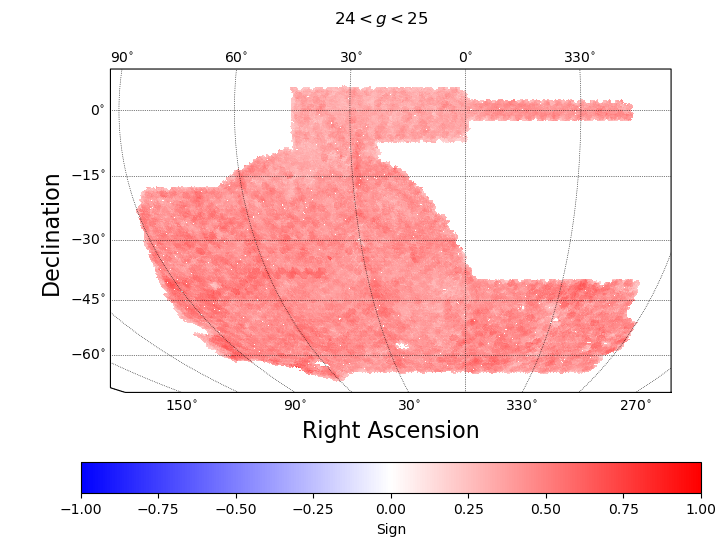

In [7]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspAssume, cmap = 'bwr')
plt.clim(-1, 1)
plt.colorbar(location = 'bottom', label = 'Sign')
fig.suptitle(r'$24<g<25$')
plt.show()

In [8]:
# plt.figure(dpi = 120)
# plt.hist(starProbs[4] + galaProbs[4] - 1, bins = np.linspace(0, 1, 201), zorder = 3)
# plt.grid(zorder = 0)
# plt.xlabel(r'$P\left( O_G|T_G\right) +P\left( O_S|T_S\right) -1$')
# plt.ylabel('Counts')
# plt.title(r'$24<g<25$')
# plt.show()

In [9]:
print(np.min(assumptionMap[validPix]))
print(np.max(assumptionMap[validPix]))
print(np.average(assumptionMap[validPix]))

0.13821836822008482
0.7633010677104841
0.41432044708126065


## Results

So far, these results have shown mostly good things, namely that the big assumption that was made is in fact true for this data up to our extended magnitude limit. However, the assumption that should automatically be true that $P\left( O_S|T_S\right)\leq 1$ is not universally holding across the sky in each magnitude bin with $g<24$ (although it is holding for $24 < g < 25$). This is obviously an issue both numerically and from an intuitive standpoint, as the probability should never be able to exceed $1$. I will now check how many pixels in total are impacted by this. If hardly any are impacted, it could likely simply be cropped off.

In [10]:
invalidPixels = np.full(12*(res**2), hp.UNSEEN)
invalidPixels[validPix] = 1
for i in np.arange(4):
    invalidPixels[validPix[np.where(starProbs[i] > 1)[0]]] = -1

In [11]:
invalidHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=invalidPixels)

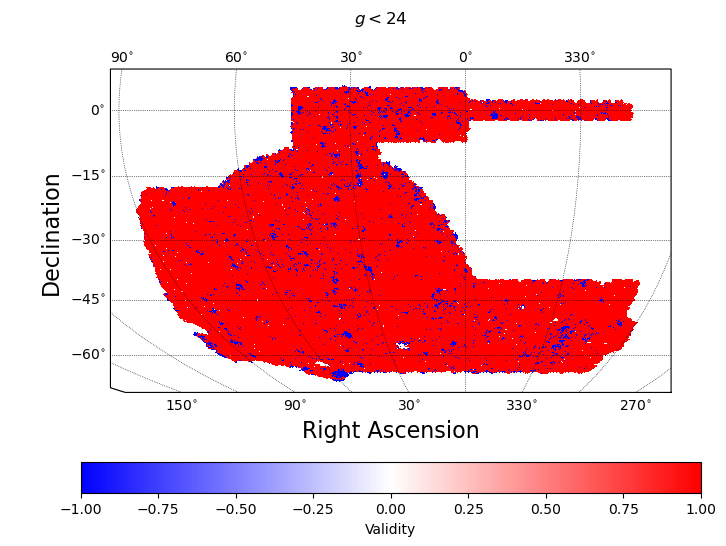

In [12]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(invalidHSP, cmap = 'bwr')
plt.clim(-1, 1)
plt.colorbar(location = 'bottom', label = 'Validity')
fig.suptitle(r'$g<24$')
plt.show()

In [13]:
print(len(np.where(invalidPixels[validPix] == -1)[0]) / len(invalidPixels[validPix]))

0.05231317268504873


In [14]:
# plt.figure(dpi = 120)
# plt.hist(1 - starProbs[0], bins = np.linspace(-0.01, 0.02, 201), zorder = 3)
# plt.grid(zorder = 0)
# plt.xlabel(r'$1-P\left( O_S|T_S\right)$')
# plt.ylabel('Counts')
# plt.title(r'$g<20$')
# plt.show()

## Analysis of Above Plot

While it is concerning to see this much blue (an invalid probability), this alone isn't enough to explain the widespread negative numbers that are being seen, and this could be eliminated by applying a cap to the probabilities of 1, which could be justified by obvious statistical arguments since the probability couldn't be over 100%. As well as this, most of these points are from the brightest magnitude bins, with all other bins contributing much less. The focus will now be turned to: $$P\left( O_G|T_G\right) + P\left( O_S\right) - 1$$

In [15]:
obsStarFiles = [galaDir + 'Obs_Star_<20.fits', galaDir + 'Obs_Star_20-22.fits', galaDir + 'Obs_Star_22-23.fits',
                 galaDir + 'Obs_Star_23-24.fits', galaDir + 'Obs_Star_24-25.fits', galaDir + 'Obs_Star_25-26.fits']

obsGalaFiles = [galaDir + 'Obs_Gala_<20.fits', galaDir + 'Obs_Gala_20-22.fits', galaDir + 'Obs_Gala_22-23.fits',
                 galaDir + 'Obs_Gala_23-24.fits', galaDir + 'Obs_Gala_24-25.fits', galaDir + 'Obs_Gala_25-26.fits']

In [16]:
obsStar = []
for obsStarFile in obsStarFiles:
    obsStar.append(fitsio.read(obsStarFile)['SIGNAL'])
obsStar = np.array(obsStar, dtype = object)

obsGala = []
for obsGalaFile in obsGalaFiles:
    obsGala.append(fitsio.read(obsGalaFile)['SIGNAL'])
obsGala = np.array(obsGala, dtype = object)

In [17]:
focusProb = np.full(12*(res**2), hp.UNSEEN)
index = 3
crop = np.where(obsStar[index] + obsGala[index] > 0)[0]
focusProb[validPix[crop]] = galaProbs[index][crop] + (obsStar[index][crop] / (obsStar[index][crop] + obsGala[index][crop])) - 1

In [18]:
focusHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=focusProb)

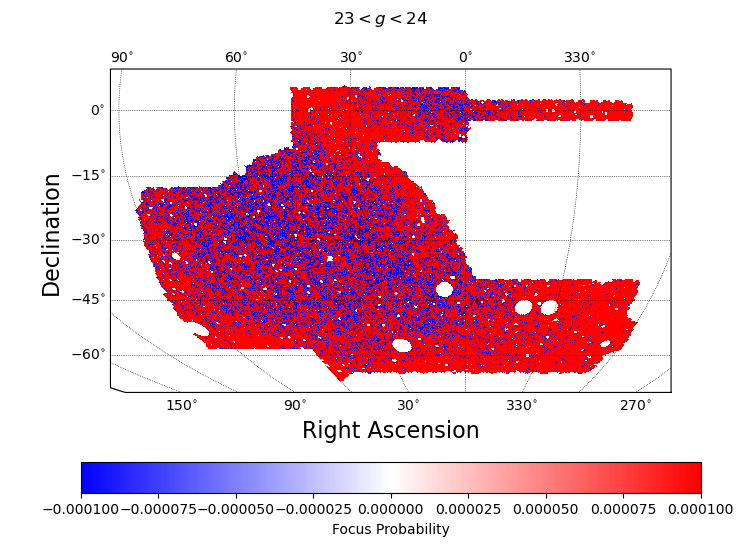

In [19]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(focusHSP, cmap = 'bwr')
plt.clim(-0.0001, 0.0001)
plt.colorbar(location = 'bottom', label = 'Focus Probability')
fig.suptitle(r'$23<g<24$')
plt.show()

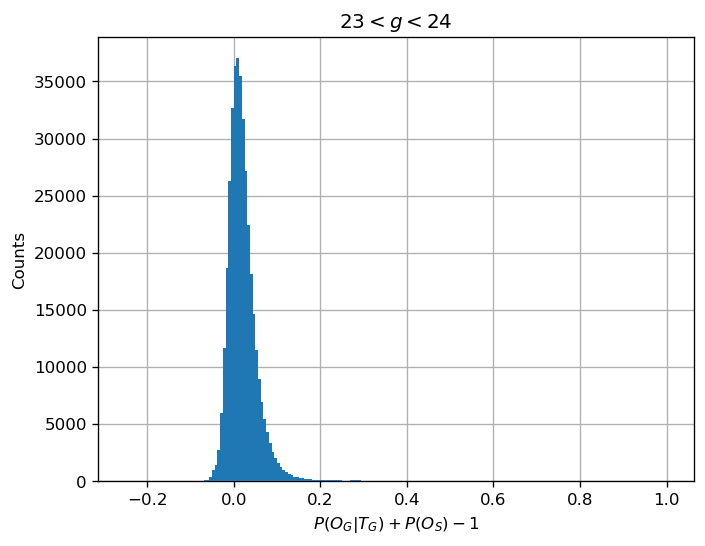

In [20]:
plt.figure(dpi = 120)
plt.hist(focusProb[validPix[crop]], bins = np.linspace(-0.25, 1, 201), zorder = 3)
plt.grid(zorder = 0)
plt.xlabel(r'$P\left( O_G|T_G\right) + P\left( O_S\right) -1$')
plt.ylabel('Counts')
plt.title(r'$23<g<24$')
plt.show()

In [21]:
print(100 * len(np.where(focusProb[validPix[crop]] < 0)[0]) / len(focusProb[validPix[crop]]))

26.75647001576788


In [22]:
print(np.min(focusProb[validPix][crop]))
print(np.max(focusProb[validPix][crop]))
print(np.average(focusProb[validPix][crop]))

-0.08442510122971614
0.9586340193839984
0.019857242616427368


# Probability Analysis

We want:

$$P\left( O_G|T_G\right) + P\left( O_S\right) - 1 = P\left( O_S\right) - P\left( O_S|T_G\right) > 0$$ 

This is equivalent to:

$$P\left( T_S\right) P\left( O_S|T_S\right) + P\left( T_G\right) P\left( O_S|T_G\right) - P\left( O_S|T_G\right) > 0$$

$$P\left( T_S\right) P\left( O_S|T_S\right) - P\left( T_S\right) P\left( O_S|T_G\right) > 0$$

We know that $P\left( T_S\right)$ will be positive, so this is finally equivalent to:

$$P\left( O_S|T_S\right) > P\left( O_S|T_G\right)$$

Even if this is negative, by the law of total probability, we should have:

$$P\left( O_S\right) > P\left( O_S|T_G\right) \iff P\left( O_S|T_S\right) > P\left( O_S|T_G\right)$$

This is why the signs should always be positive for the final resulting probabilities, but obviously some things are going wrong.

# Sign Determination

Assuming that probabilities start getting cropped at 1 to eliminate issues shown above, the sign will be determined by:

$$\frac{P\left( O_G|T_G\right) + P\left( O_S\right) - 1}{P\left( O_G|T_G\right) + P\left( O_S|T_S\right) - 1}$$

Above I was looking at the numerator of this, so now I will look instead at the denominator.

In [23]:
# denom = np.full(12*(res**2), hp.UNSEEN)
# denom[validPix] = galaProbs[index] + starProbs[index] - 1

In [24]:
# denomHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=denom)

In [25]:
# The default DES projection is a McBrydeSkymap.
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(denomHSP, cmap = 'bwr')
# plt.clim(-0.0001, 0.0001)
# plt.colorbar(location = 'bottom', label = 'Denominator Sign')
# fig.suptitle(r'$23<g<24$')
# plt.show()

In [26]:
# print(np.min(denom[validPix]))